In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, ARDRegression, SGDRegressor, PassiveAggressiveRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor, StackingRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from models import MLP, Ensemble, FONN1, FONN2, TREENN1, TREENN2

In [2]:
# Load the store sales dataset
excel_file = pd.ExcelFile('data/store_sales.xlsx')
sheet_names = excel_file.sheet_names

# Read the data
df = pd.read_excel(excel_file, sheet_name=sheet_names[0])
iri_key_counts = df["IRI_KEY"].value_counts()
iri_keys = iri_key_counts[iri_key_counts > 300].index


features = ["F", "D", "Unit.Price"]
target = "Total.Volume"

df = df[df["IRI_KEY"] == iri_keys[1]]
X = df[features]
y = df[target].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

sheet_names, iri_keys, X.shape, y.shape

(['StoreWeekSalescarbbev_modify',
  'StoreWeekSalescigets',
  'StoreWeekSalescoffee',
  'StoreWeekSalescoldcer',
  'StoreWeekSalesdeod',
  'StoreWeekSalesdiapers',
  'StoreWeekSalesfactiss',
  'StoreWeekSalesfzdinent',
  'StoreWeekSalesfzpizza',
  'StoreWeekSaleshotdog',
  'StoreWeekSaleslaundet',
  'StoreWeekSalesmargbutr',
  'StoreWeekSalesmayo',
  'StoreWeekSalesmustketc',
  'StoreWeekSalespaptowl',
  'StoreWeekSalespeanbutr',
  'StoreWeekSalesshamp',
  'StoreWeekSalessoup',
  'StoreWeekSalesspagsauc',
  'StoreWeekSalessugarsub',
  'StoreWeekSalestoitisu',
  'StoreWeekSalestoothpa',
  'StoreWeekSalesyogurt',
  'StoreWeekSalesbeer_modify'],
 Index([6001821.0,  648368.0,  279300.0,  400003.0,  270862.0,  231720.0,
         252570.0,  659827.0,  241565.0,  237277.0,  291276.0,  273920.0,
         232633.0,  233246.0,  532639.0,  533864.0],
       dtype='float64', name='IRI_KEY'),
 (313, 3),
 (313,))

In [3]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((250, 3), (63, 3), (250,), (63,))

In [4]:
# Function to train and evaluate a model
def train_evaluate_model(model, X_train, X_test, y_train, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    train_time = end_time - start_time

    start_time = time.time()
    predictions = model.predict(X_test)
    end_time = time.time()
    comp_time = end_time - start_time

    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)

    return r2, mae, mse, train_time, comp_time


# Train and evaluate models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "ElasticNet Regression": ElasticNet(),
    "Bayesian Ridge Regression": BayesianRidge(),
    "ARD Regression": ARDRegression(),
    "SGD Regressor": SGDRegressor(),
    "Passive Aggressive Regressor": PassiveAggressiveRegressor(),
    "Support Vector Regression": SVR(),
    "MLP Regressor": MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42),
    "XGBoost Regressor": XGBRegressor(random_state=42),
    "AdaBoost Regressor": AdaBoostRegressor(random_state=42),
    "Bagging Regressor": BaggingRegressor(random_state=42),
    "ExtraTrees Regressor": ExtraTreesRegressor(random_state=42),
    "HistGradientBoosting Regressor": HistGradientBoostingRegressor(random_state=42),
    "Stacking Regressor": StackingRegressor(estimators=[
        ('lr', LinearRegression()),
        ('rf', RandomForestRegressor(n_estimators=10, random_state=42))
    ], final_estimator=Ridge()),
    "Voting Regressor": VotingRegressor(estimators=[
        ('lr', LinearRegression()),
        ('rf', RandomForestRegressor(n_estimators=10, random_state=42)),
        ('gb', GradientBoostingRegressor(random_state=42))
    ])
}


In [5]:
# Initialize custom models
input_dim = X_train.shape[1]
hidden_dim = 10
output_dim = 1
learning_rate = 0.005
epochs = 2000

models["Custom MLP"] = MLP(input_dim, hidden_dim, output_dim,
                           learning_rate=learning_rate, epochs=epochs)

num_trees_input = 10
models["FONN1"] = FONN1(input_dim, hidden_dim, output_dim, num_trees_input,
                        learning_rate=learning_rate, epochs=epochs)
models["Tree-based Predictions (FONN1)"] = models["FONN1"].trees

num_trees_hidden = 10
models["FONN2"] = FONN2(input_dim, hidden_dim, output_dim, num_trees_hidden,
                        learning_rate=learning_rate, epochs=epochs)
models["Tree-based Predictions (FONN2)"] = models["FONN2"].trees

models["TREENN1"] = TREENN1(input_dim, hidden_dim, output_dim,
                            learning_rate=learning_rate, epochs=epochs)
models["Tree-based Predictions (TREENN1)"] = models["TREENN1"].trees

models["TREENN2"] = TREENN2(input_dim, hidden_dim, output_dim,
                            learning_rate=learning_rate, epochs=epochs)
models["Tree-based Predictions (TREENN2)"] = models["TREENN2"].trees

models["Ensemble of 10 Trees"] = Ensemble(10)

In [6]:
# Train and evaluate models
results = {}
for name, model in models.items():
    r2, mae, mse, fit_time, comp_time = train_evaluate_model(
        model, X_train, X_test, y_train, y_test)
    results[name] = {"R² Score": r2, "MAE": mae, "MSE": mse,
                     "Train Time (s)": fit_time, "Comp Time (s)": comp_time}

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results).T
results_df

/home/chess/anaconda3/envs/research/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 0, Loss: 9113892.02871362
Epoch 100, Loss: 9089294.708411235
Epoch 200, Loss: 9047065.151326204
Epoch 300, Loss: 9001265.242340235
Epoch 400, Loss: 8963424.499468487
Epoch 500, Loss: 8929102.601743886
Epoch 600, Loss: 8896343.447096286
Epoch 700, Loss: 8864356.95858813
Epoch 800, Loss: 8832749.532296132
Epoch 900, Loss: 8801340.07062717
Epoch 1000, Loss: 8770049.02953429
Epoch 1100, Loss: 8738842.476882374
Epoch 1200, Loss: 8707707.41189727
Epoch 1300, Loss: 8676636.50199615
Epoch 1400, Loss: 8645626.98121987
Epoch 1500, Loss: 8614678.309297567
Epoch 1600, Loss: 8583790.310454037
Epoch 1700, Loss: 8552962.910229346
Epoch 1800, Loss: 8522196.071638592
Epoch 1900, Loss: 8491489.77421225
Epoch 0, Loss: 9120210.146572286
Epoch 100, Loss: 9088348.611755036
Epoch 200, Loss: 9056547.576937787
Epoch 300, Loss: 9024807.04212054
Epoch 400, Loss: 8993127.00730329
Epoch 500, Loss: 8961507.472486041
Epoch 600, Loss: 8929948.437668793
Epoch 700, Loss: 8898449.902851544
Epoch 800, Loss: 8867011

,R² Score,MAE,MSE,Train Time (s),Comp Time (s)
Linear Regression,0.529052,300.356074,1.348929e+05,0.016880,0.000276
Ridge Regression,0.533819,298.904336,1.335274e+05,0.000924,0.000090
Lasso Regression,0.531657,299.689407,1.341467e+05,0.000491,0.000082
ElasticNet Regression,0.685661,230.078266,9.003577e+04,0.000929,0.000100
Bayesian Ridge Regression,0.536318,298.132666,1.328116e+05,0.000761,0.000069
ARD Regression,0.537218,298.646086,1.325541e+05,0.001703,0.000091
SGD Regressor,0.531098,299.334473,1.343071e+05,0.000878,0.000084
Passive Aggressive Regressor,0.682575,234.772121,9.091951e+04,0.000558,0.000067
Support Vector Regression,0.015288,423.000709,2.820495e+05,0.002259,0.000689
MLP Regressor,-12.277504,1881.747838,3.803056e+06,0.431582,0.000191


Tree 0 feature importances:
[0.01648926 0.06916565 0.91434509]
Tree 0 structure:
|--- feature_2 <= -0.53
|   |--- feature_2 <= -1.61
|   |   |--- feature_2 <= -2.38
|   |   |   |--- feature_1 <= 0.32
|   |   |   |   |--- feature_0 <= -1.73
|   |   |   |   |   |--- value: [5620.66]
|   |   |   |   |--- feature_0 >  -1.73
|   |   |   |   |   |--- value: [4816.08]
|   |   |   |--- feature_1 >  0.32
|   |   |   |   |--- feature_0 <= 1.31
|   |   |   |   |   |--- value: [6887.82]
|   |   |   |   |--- feature_0 >  1.31
|   |   |   |   |   |--- value: [6689.66]
|   |   |--- feature_2 >  -2.38
|   |   |   |--- feature_2 <= -1.83
|   |   |   |   |--- feature_0 <= 1.40
|   |   |   |   |   |--- value: [4563.76]
|   |   |   |   |--- feature_0 >  1.40
|   |   |   |   |   |--- value: [4973.33]
|   |   |   |--- feature_2 >  -1.83
|   |   |   |   |--- feature_0 <= 0.36
|   |   |   |   |   |--- value: [4772.00]
|   |   |   |   |--- feature_0 >  0.36
|   |   |   |   |   |--- value: [4210.68]
|   |--- fe

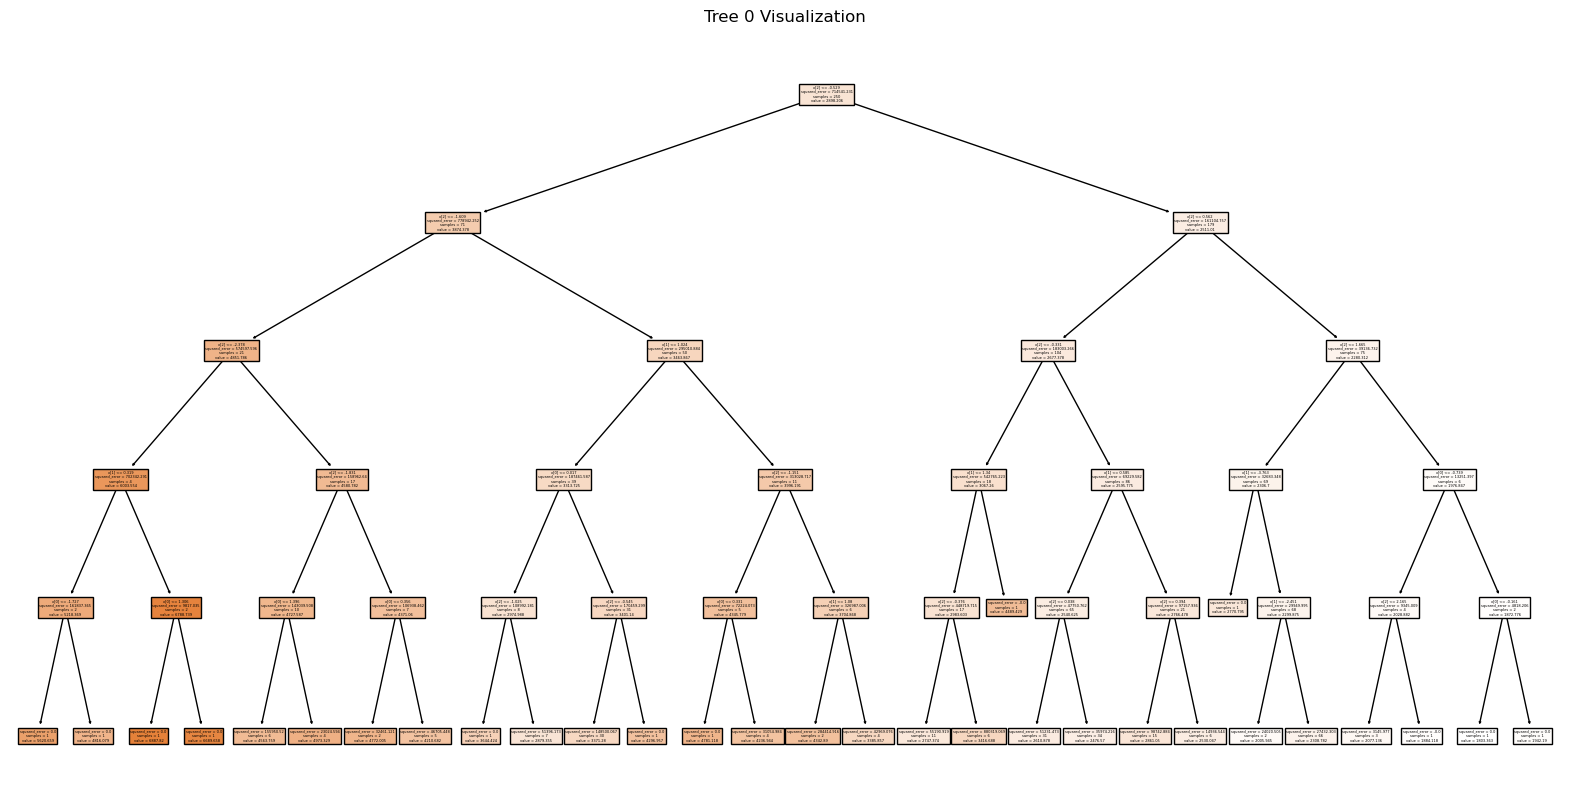

Tree 1 feature importances:
[0.01427631 0.06916565 0.91655805]
Tree 1 structure:
|--- feature_2 <= -0.53
|   |--- feature_2 <= -1.61
|   |   |--- feature_2 <= -2.38
|   |   |   |--- feature_1 <= 0.32
|   |   |   |   |--- feature_2 <= -2.56
|   |   |   |   |   |--- value: [5620.66]
|   |   |   |   |--- feature_2 >  -2.56
|   |   |   |   |   |--- value: [4816.08]
|   |   |   |--- feature_1 >  0.32
|   |   |   |   |--- feature_2 <= -2.45
|   |   |   |   |   |--- value: [6689.66]
|   |   |   |   |--- feature_2 >  -2.45
|   |   |   |   |   |--- value: [6887.82]
|   |   |--- feature_2 >  -2.38
|   |   |   |--- feature_2 <= -1.83
|   |   |   |   |--- feature_0 <= 1.40
|   |   |   |   |   |--- value: [4563.76]
|   |   |   |   |--- feature_0 >  1.40
|   |   |   |   |   |--- value: [4973.33]
|   |   |   |--- feature_2 >  -1.83
|   |   |   |   |--- feature_0 <= 0.36
|   |   |   |   |   |--- value: [4772.00]
|   |   |   |   |--- feature_0 >  0.36
|   |   |   |   |   |--- value: [4210.68]
|   |--- 

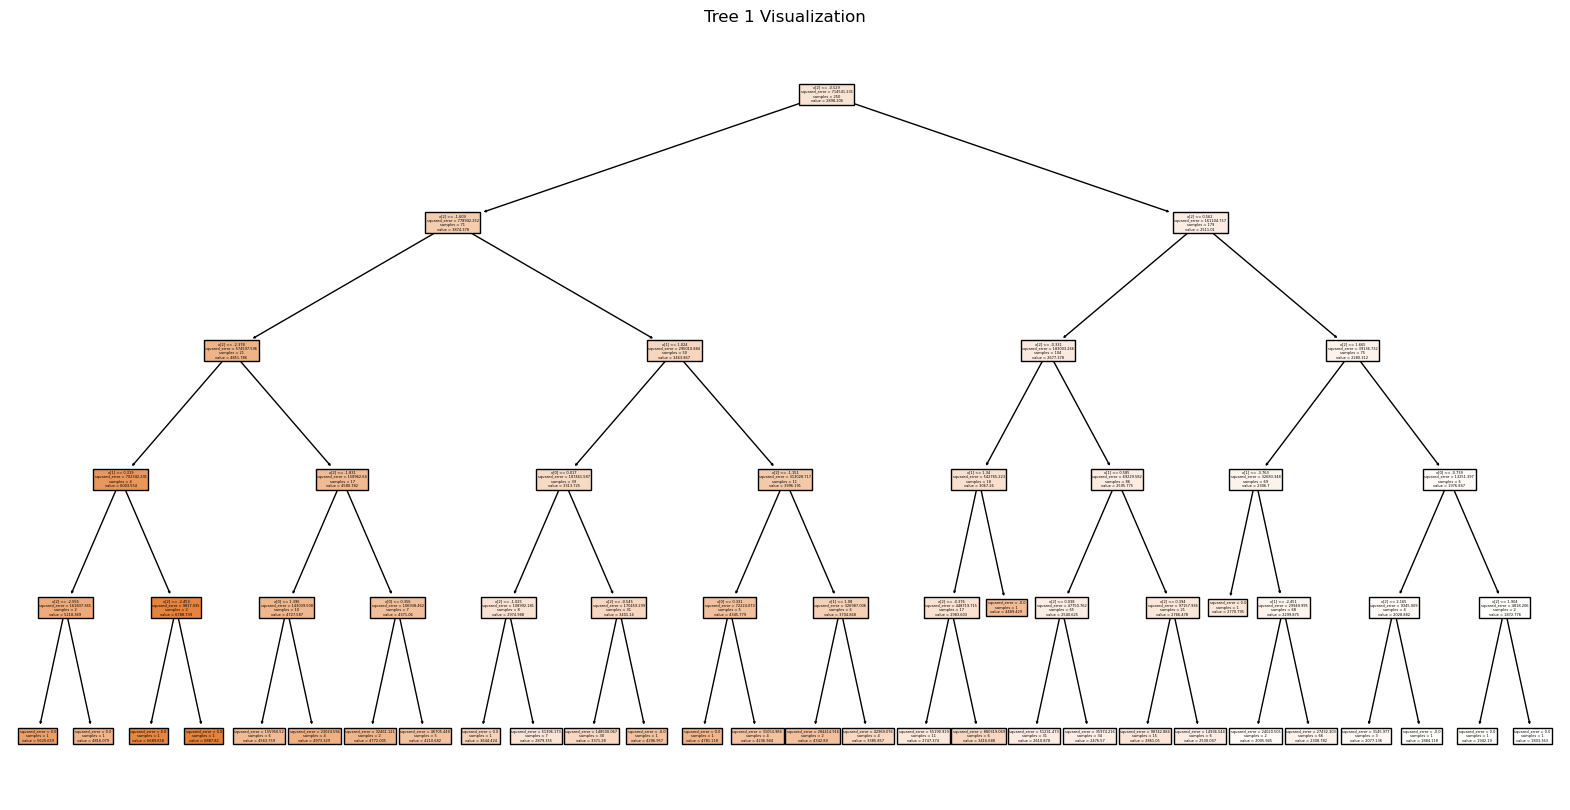

Tree 2 feature importances:
[0.01433673 0.06916565 0.91649763]
Tree 2 structure:
|--- feature_2 <= -0.53
|   |--- feature_2 <= -1.61
|   |   |--- feature_2 <= -2.38
|   |   |   |--- feature_1 <= 0.32
|   |   |   |   |--- feature_2 <= -2.56
|   |   |   |   |   |--- value: [5620.66]
|   |   |   |   |--- feature_2 >  -2.56
|   |   |   |   |   |--- value: [4816.08]
|   |   |   |--- feature_1 >  0.32
|   |   |   |   |--- feature_2 <= -2.45
|   |   |   |   |   |--- value: [6689.66]
|   |   |   |   |--- feature_2 >  -2.45
|   |   |   |   |   |--- value: [6887.82]
|   |   |--- feature_2 >  -2.38
|   |   |   |--- feature_2 <= -1.83
|   |   |   |   |--- feature_0 <= 1.40
|   |   |   |   |   |--- value: [4563.76]
|   |   |   |   |--- feature_0 >  1.40
|   |   |   |   |   |--- value: [4973.33]
|   |   |   |--- feature_2 >  -1.83
|   |   |   |   |--- feature_0 <= 0.36
|   |   |   |   |   |--- value: [4772.00]
|   |   |   |   |--- feature_0 >  0.36
|   |   |   |   |   |--- value: [4210.68]
|   |--- 

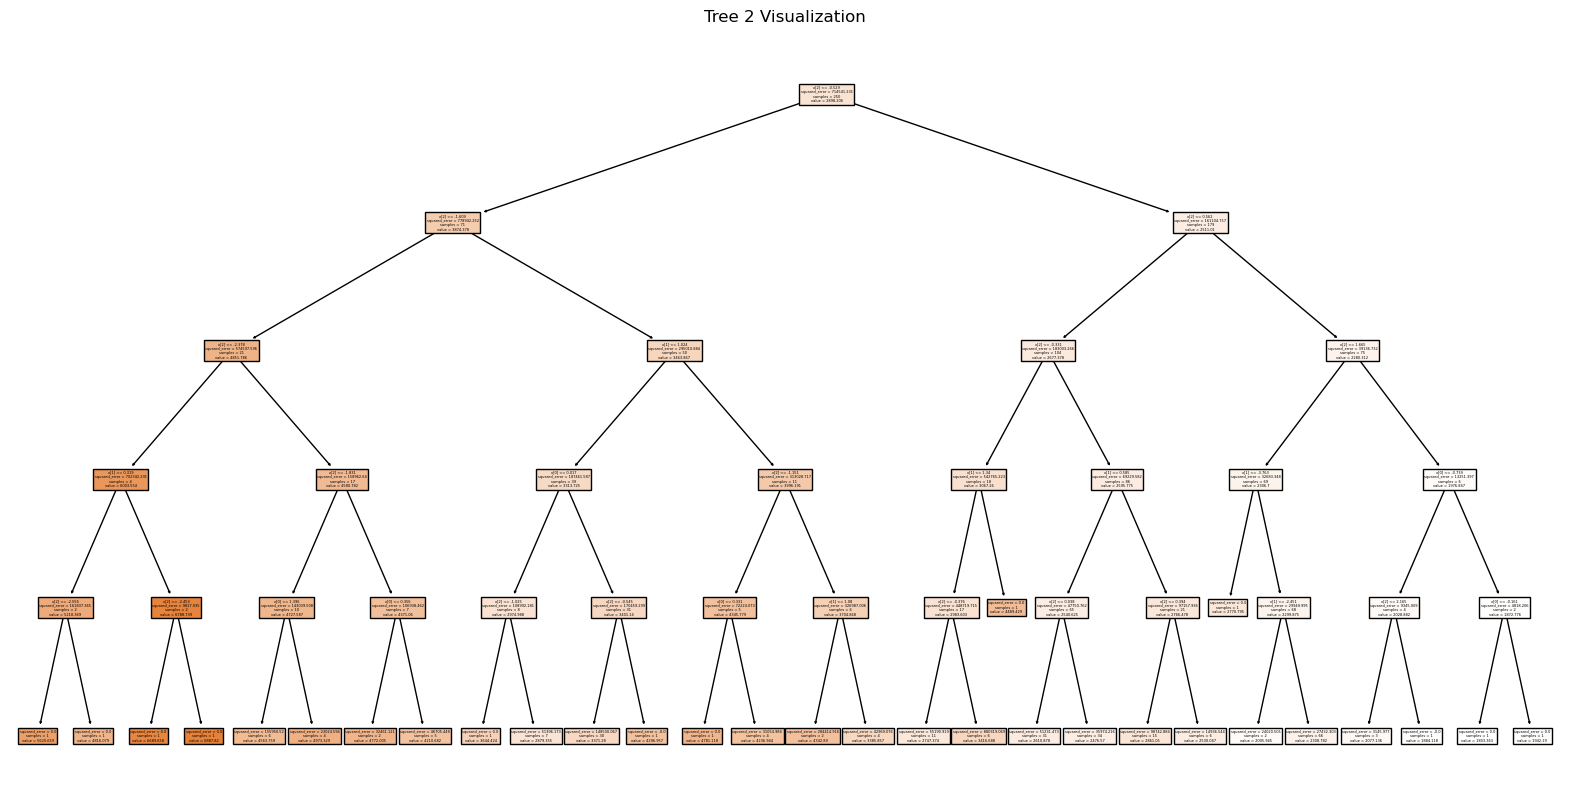

Tree 3 feature importances:
[0.01439941 0.06916565 0.91643494]
Tree 3 structure:
|--- feature_2 <= -0.53
|   |--- feature_2 <= -1.61
|   |   |--- feature_2 <= -2.38
|   |   |   |--- feature_1 <= 0.32
|   |   |   |   |--- feature_2 <= -2.56
|   |   |   |   |   |--- value: [5620.66]
|   |   |   |   |--- feature_2 >  -2.56
|   |   |   |   |   |--- value: [4816.08]
|   |   |   |--- feature_1 >  0.32
|   |   |   |   |--- feature_0 <= 1.31
|   |   |   |   |   |--- value: [6887.82]
|   |   |   |   |--- feature_0 >  1.31
|   |   |   |   |   |--- value: [6689.66]
|   |   |--- feature_2 >  -2.38
|   |   |   |--- feature_2 <= -1.83
|   |   |   |   |--- feature_0 <= 1.40
|   |   |   |   |   |--- value: [4563.76]
|   |   |   |   |--- feature_0 >  1.40
|   |   |   |   |   |--- value: [4973.33]
|   |   |   |--- feature_2 >  -1.83
|   |   |   |   |--- feature_0 <= 0.36
|   |   |   |   |   |--- value: [4772.00]
|   |   |   |   |--- feature_0 >  0.36
|   |   |   |   |   |--- value: [4210.68]
|   |--- fe

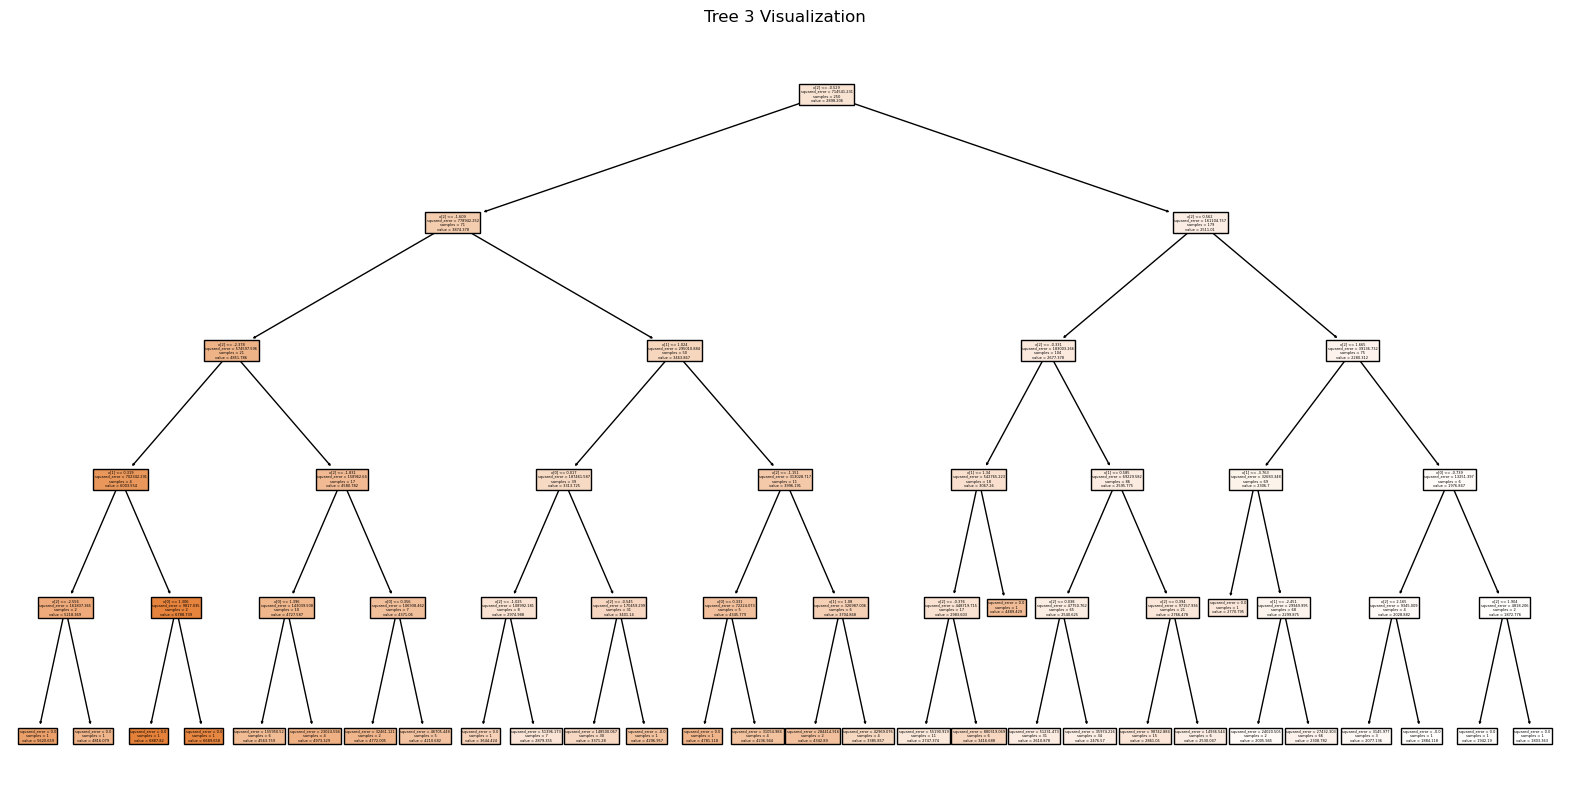

Tree 4 feature importances:
[0.01439941 0.07119508 0.91440551]
Tree 4 structure:
|--- feature_2 <= -0.53
|   |--- feature_2 <= -1.61
|   |   |--- feature_2 <= -2.38
|   |   |   |--- feature_1 <= 0.32
|   |   |   |   |--- feature_1 <= -0.47
|   |   |   |   |   |--- value: [4816.08]
|   |   |   |   |--- feature_1 >  -0.47
|   |   |   |   |   |--- value: [5620.66]
|   |   |   |--- feature_1 >  0.32
|   |   |   |   |--- feature_0 <= 1.31
|   |   |   |   |   |--- value: [6887.82]
|   |   |   |   |--- feature_0 >  1.31
|   |   |   |   |   |--- value: [6689.66]
|   |   |--- feature_2 >  -2.38
|   |   |   |--- feature_2 <= -1.83
|   |   |   |   |--- feature_0 <= 1.40
|   |   |   |   |   |--- value: [4563.76]
|   |   |   |   |--- feature_0 >  1.40
|   |   |   |   |   |--- value: [4973.33]
|   |   |   |--- feature_2 >  -1.83
|   |   |   |   |--- feature_0 <= 0.36
|   |   |   |   |   |--- value: [4772.00]
|   |   |   |   |--- feature_0 >  0.36
|   |   |   |   |   |--- value: [4210.68]
|   |--- fe

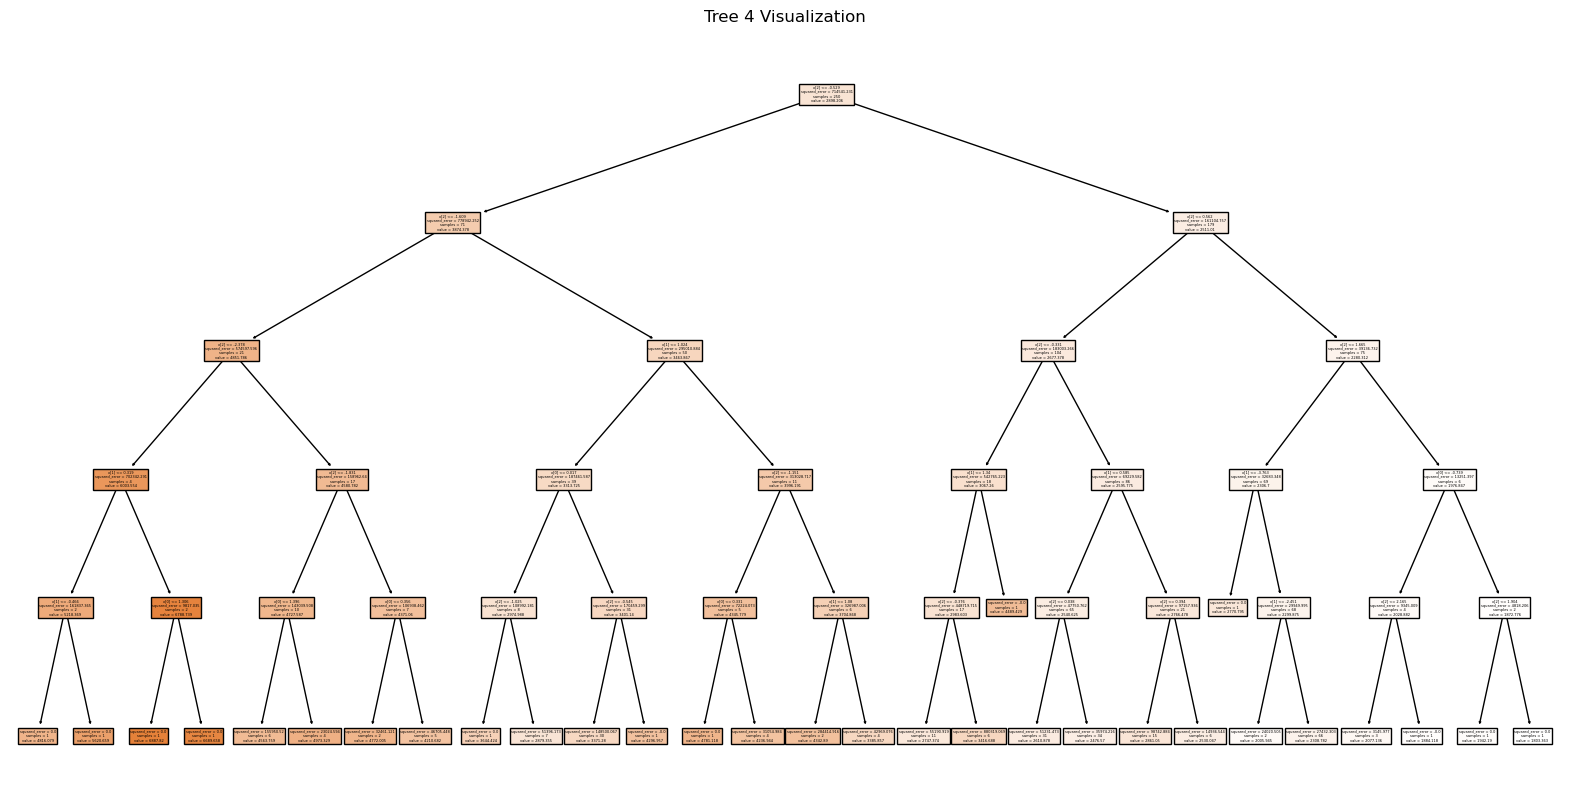

Tree 5 feature importances:
[0.01445983 0.07119508 0.91434509]
Tree 5 structure:
|--- feature_2 <= -0.53
|   |--- feature_2 <= -1.61
|   |   |--- feature_2 <= -2.38
|   |   |   |--- feature_1 <= 0.32
|   |   |   |   |--- feature_1 <= -0.47
|   |   |   |   |   |--- value: [4816.08]
|   |   |   |   |--- feature_1 >  -0.47
|   |   |   |   |   |--- value: [5620.66]
|   |   |   |--- feature_1 >  0.32
|   |   |   |   |--- feature_0 <= 1.31
|   |   |   |   |   |--- value: [6887.82]
|   |   |   |   |--- feature_0 >  1.31
|   |   |   |   |   |--- value: [6689.66]
|   |   |--- feature_2 >  -2.38
|   |   |   |--- feature_2 <= -1.83
|   |   |   |   |--- feature_0 <= 1.40
|   |   |   |   |   |--- value: [4563.76]
|   |   |   |   |--- feature_0 >  1.40
|   |   |   |   |   |--- value: [4973.33]
|   |   |   |--- feature_2 >  -1.83
|   |   |   |   |--- feature_0 <= 0.36
|   |   |   |   |   |--- value: [4772.00]
|   |   |   |   |--- feature_0 >  0.36
|   |   |   |   |   |--- value: [4210.68]
|   |--- fe

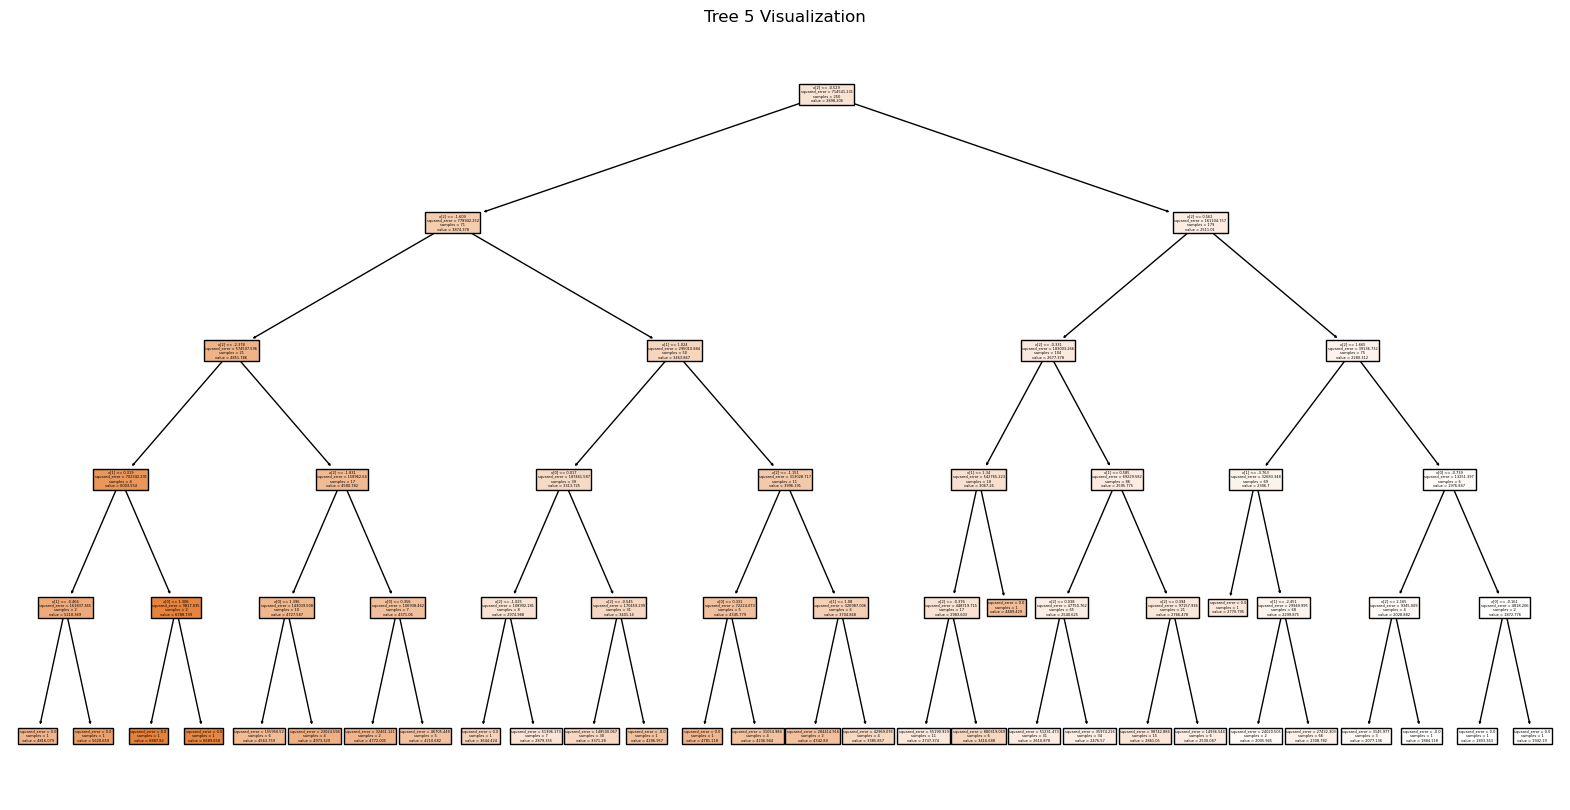

Tree 6 feature importances:
[0.01642884 0.06916565 0.91440551]
Tree 6 structure:
|--- feature_2 <= -0.53
|   |--- feature_2 <= -1.61
|   |   |--- feature_2 <= -2.38
|   |   |   |--- feature_1 <= 0.32
|   |   |   |   |--- feature_0 <= -1.73
|   |   |   |   |   |--- value: [5620.66]
|   |   |   |   |--- feature_0 >  -1.73
|   |   |   |   |   |--- value: [4816.08]
|   |   |   |--- feature_1 >  0.32
|   |   |   |   |--- feature_0 <= 1.31
|   |   |   |   |   |--- value: [6887.82]
|   |   |   |   |--- feature_0 >  1.31
|   |   |   |   |   |--- value: [6689.66]
|   |   |--- feature_2 >  -2.38
|   |   |   |--- feature_2 <= -1.83
|   |   |   |   |--- feature_0 <= 1.40
|   |   |   |   |   |--- value: [4563.76]
|   |   |   |   |--- feature_0 >  1.40
|   |   |   |   |   |--- value: [4973.33]
|   |   |   |--- feature_2 >  -1.83
|   |   |   |   |--- feature_0 <= 0.36
|   |   |   |   |   |--- value: [4772.00]
|   |   |   |   |--- feature_0 >  0.36
|   |   |   |   |   |--- value: [4210.68]
|   |--- fe

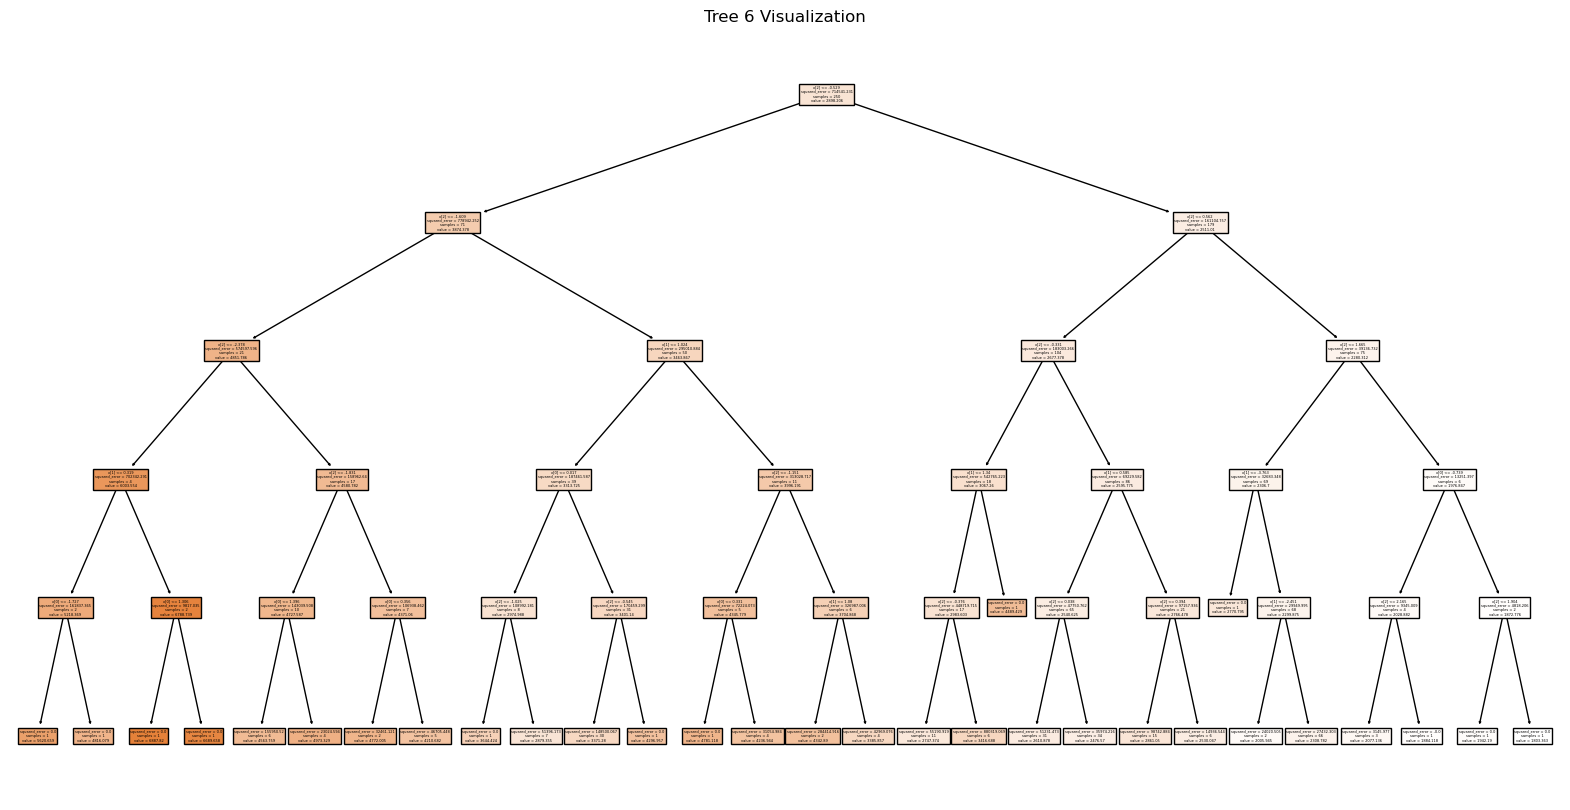

Tree 7 feature importances:
[0.01630574 0.06934917 0.91434509]
Tree 7 structure:
|--- feature_2 <= -0.53
|   |--- feature_2 <= -1.61
|   |   |--- feature_2 <= -2.38
|   |   |   |--- feature_1 <= 0.32
|   |   |   |   |--- feature_0 <= -1.73
|   |   |   |   |   |--- value: [5620.66]
|   |   |   |   |--- feature_0 >  -1.73
|   |   |   |   |   |--- value: [4816.08]
|   |   |   |--- feature_1 >  0.32
|   |   |   |   |--- feature_1 <= 1.10
|   |   |   |   |   |--- value: [6689.66]
|   |   |   |   |--- feature_1 >  1.10
|   |   |   |   |   |--- value: [6887.82]
|   |   |--- feature_2 >  -2.38
|   |   |   |--- feature_2 <= -1.83
|   |   |   |   |--- feature_0 <= 1.40
|   |   |   |   |   |--- value: [4563.76]
|   |   |   |   |--- feature_0 >  1.40
|   |   |   |   |   |--- value: [4973.33]
|   |   |   |--- feature_2 >  -1.83
|   |   |   |   |--- feature_0 <= 0.36
|   |   |   |   |   |--- value: [4772.00]
|   |   |   |   |--- feature_0 >  0.36
|   |   |   |   |   |--- value: [4210.68]
|   |--- fe

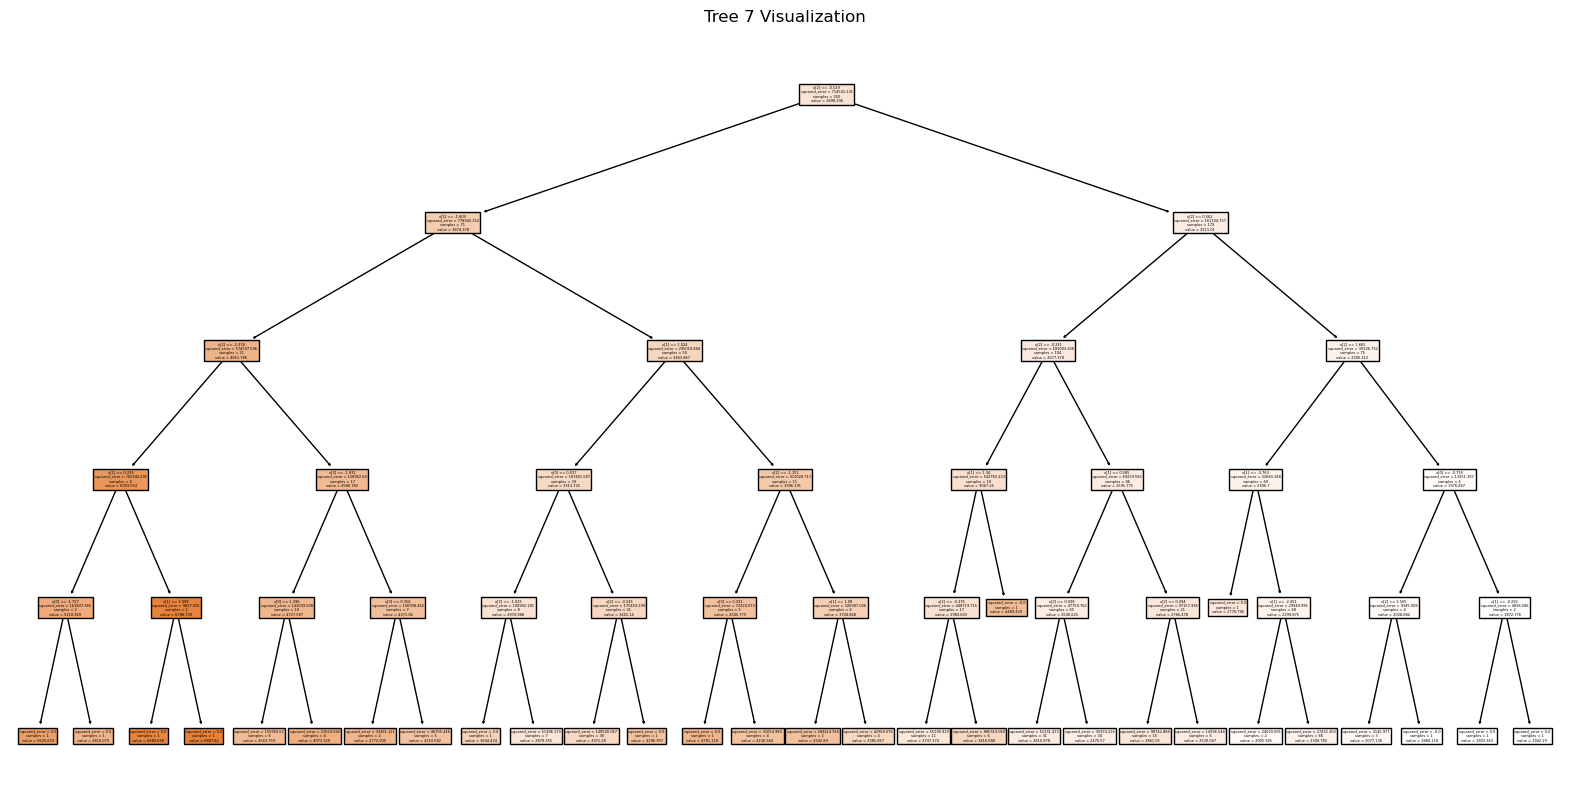

Tree 8 feature importances:
[0.01427631 0.07131818 0.91440551]
Tree 8 structure:
|--- feature_2 <= -0.53
|   |--- feature_2 <= -1.61
|   |   |--- feature_2 <= -2.38
|   |   |   |--- feature_1 <= 0.32
|   |   |   |   |--- feature_1 <= -0.47
|   |   |   |   |   |--- value: [4816.08]
|   |   |   |   |--- feature_1 >  -0.47
|   |   |   |   |   |--- value: [5620.66]
|   |   |   |--- feature_1 >  0.32
|   |   |   |   |--- feature_1 <= 1.10
|   |   |   |   |   |--- value: [6689.66]
|   |   |   |   |--- feature_1 >  1.10
|   |   |   |   |   |--- value: [6887.82]
|   |   |--- feature_2 >  -2.38
|   |   |   |--- feature_2 <= -1.83
|   |   |   |   |--- feature_0 <= 1.40
|   |   |   |   |   |--- value: [4563.76]
|   |   |   |   |--- feature_0 >  1.40
|   |   |   |   |   |--- value: [4973.33]
|   |   |   |--- feature_2 >  -1.83
|   |   |   |   |--- feature_0 <= 0.36
|   |   |   |   |   |--- value: [4772.00]
|   |   |   |   |--- feature_0 >  0.36
|   |   |   |   |   |--- value: [4210.68]
|   |--- fe

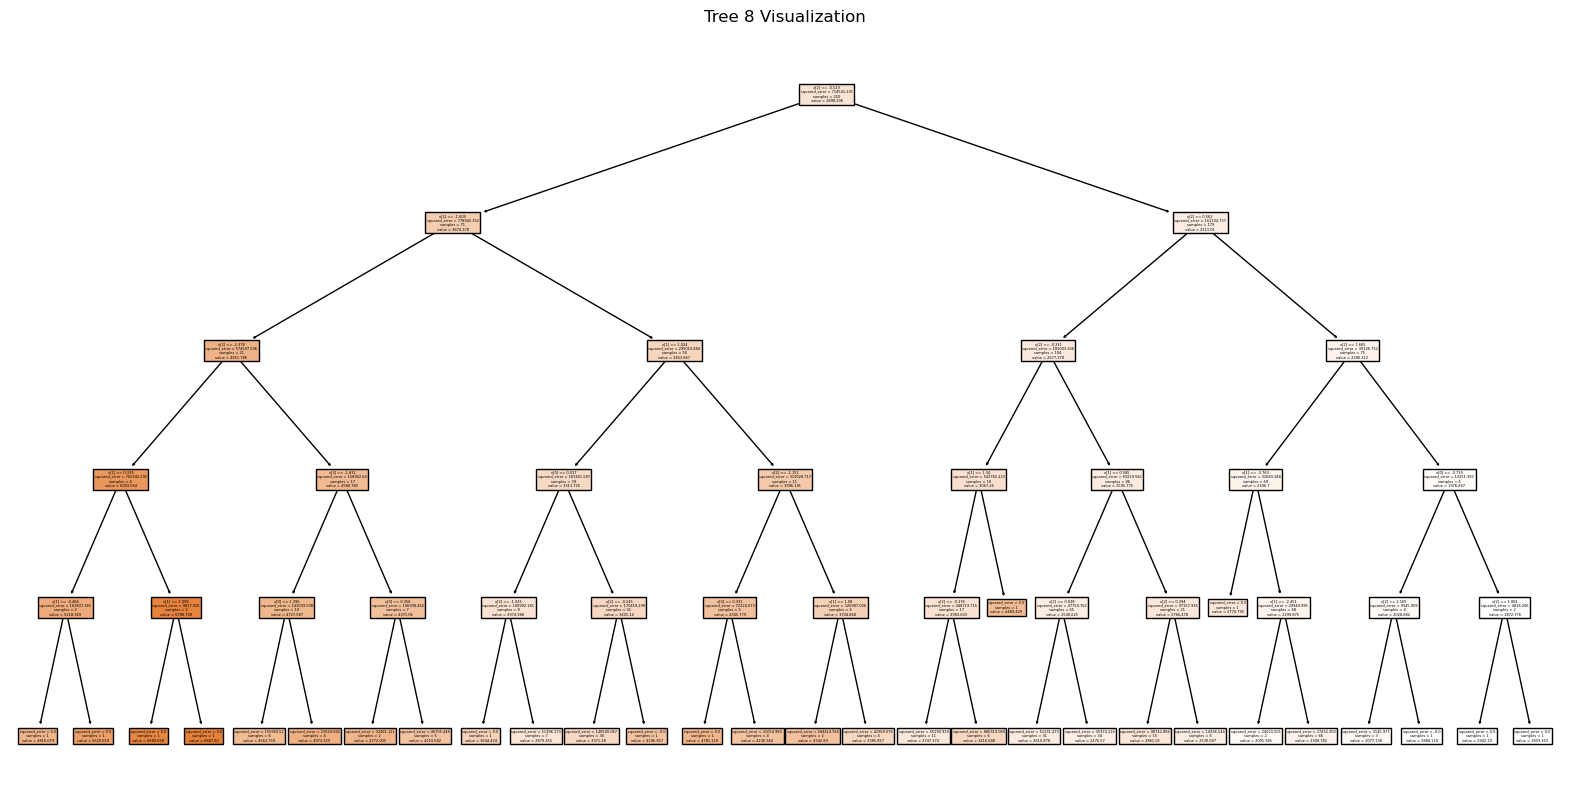

Tree 9 feature importances:
[0.01439941 0.0712555  0.91434509]
Tree 9 structure:
|--- feature_2 <= -0.53
|   |--- feature_2 <= -1.61
|   |   |--- feature_2 <= -2.38
|   |   |   |--- feature_1 <= 0.32
|   |   |   |   |--- feature_1 <= -0.47
|   |   |   |   |   |--- value: [4816.08]
|   |   |   |   |--- feature_1 >  -0.47
|   |   |   |   |   |--- value: [5620.66]
|   |   |   |--- feature_1 >  0.32
|   |   |   |   |--- feature_0 <= 1.31
|   |   |   |   |   |--- value: [6887.82]
|   |   |   |   |--- feature_0 >  1.31
|   |   |   |   |   |--- value: [6689.66]
|   |   |--- feature_2 >  -2.38
|   |   |   |--- feature_2 <= -1.83
|   |   |   |   |--- feature_0 <= 1.40
|   |   |   |   |   |--- value: [4563.76]
|   |   |   |   |--- feature_0 >  1.40
|   |   |   |   |   |--- value: [4973.33]
|   |   |   |--- feature_2 >  -1.83
|   |   |   |   |--- feature_0 <= 0.36
|   |   |   |   |   |--- value: [4772.00]
|   |   |   |   |--- feature_0 >  0.36
|   |   |   |   |   |--- value: [4210.68]
|   |--- fe

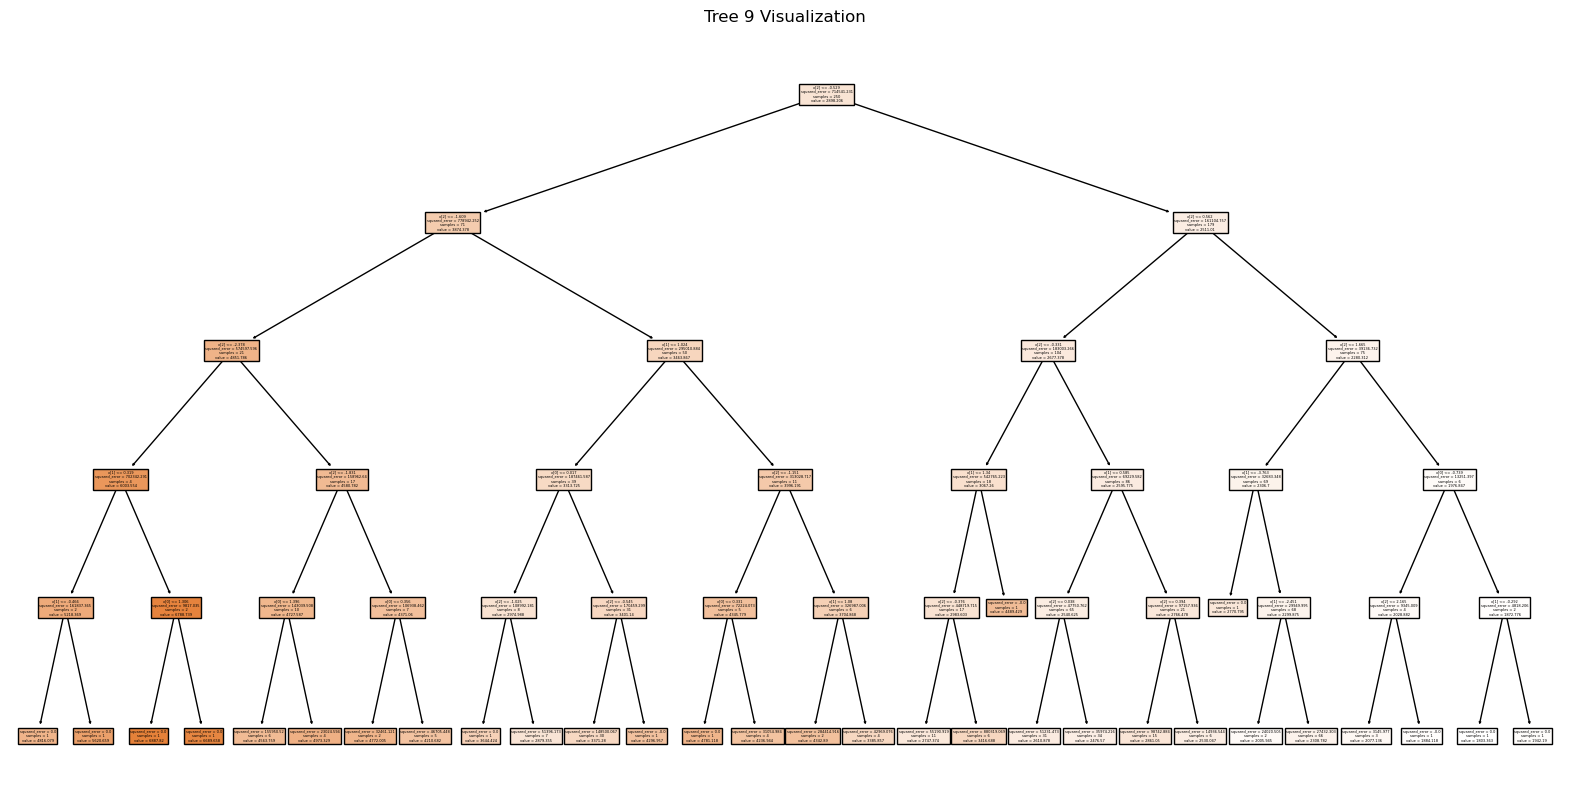

In [7]:
# Get and print tree importances
tree_importances = models["FONN2"].trees.get_tree_importances()